In [1]:
import os
import re
import struct
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from program import Box
import rasterio as rio
from rasterio.plot import show
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from dependencies import Box, GeoTIFF

In [2]:
def get_shape_bounds(shp_file:str) -> (float):
    with open(shp_file, 'rb') as f:
        bound_bytes = f.read()[36:68]    
        return Box(None,
            int(struct.unpack("d", bound_bytes[:8])[0]),
            int(struct.unpack("d", bound_bytes[8:16])[0]),
            int(struct.unpack("d", bound_bytes[16:24])[0]),
            int(struct.unpack("d", bound_bytes[24:32])[0]))

In [3]:
shape_bounds = {}
shape_dir = "./Shapes/"
shape_types = ["Bpn_CaBl","Bpn_CaBu","Bpn_ReBu"]
for province in os.listdir(shape_dir):
    shape_bounds[province] = {}
    province_dir = shape_dir +province +"/"
    if os.path.isdir(province_dir):
        place_list = os.listdir(province_dir)
        place_list.sort()
        for place in place_list:
            shape_bounds[province][place] = {}
            place_dir = province_dir +place +"/"
            file_list = os.listdir(place_dir)
            for shape_file in shape_types:
                file_path = place_dir +shape_file +".shp"
                bounds = get_shape_bounds(file_path) if shape_file +".shp" in file_list else np.nan
                shape_bounds[province][place][shape_file] = bounds

## Creates shape_lookup.csv

In [4]:
shape_lookup = pd.DataFrame(columns = ["Place","Province","CaBl","CaBu","ReBu"])
for province, places in shape_bounds.items():
    for place, bounds in places.items():
        shape_lookup = shape_lookup.append({
            "Place": place,
            "Province": province,
            "CaBl": repr(bounds["Bpn_CaBl"]),
            "CaBu": repr(bounds["Bpn_CaBu"]),
            "ReBu": repr(bounds["Bpn_ReBu"])},
        ignore_index=True, sort = False)
shape_lookup.to_csv("./Shapes/shape_lookup.csv", index=False, sep="|") 

In [2]:
shape_lookup = pd.read_csv("./Shapes/shape_lookup.csv", sep="|")
shape_lookup

,Place,Province,CaBl,CaBu,ReBu
0,Aartselaar,Antwerpen,148952 199943 152798 204560 3846 4617,NaN,148977 199945 152668 204502 3691 4557
1,Antwerpen,Antwerpen,141272 203701 159026 229767 17754 26066,147923 207345 157827 214886 9904 7541,141490 203963 159013 229762 17523 25799
2,Arendonk,Antwerpen,196056 220435 203829 231746 7773 11311,199191 223404 199229 223445 38 41,196127 220782 203647 230679 7520 9897
3,Baarle-Hertog,Antwerpen,181838 231590 190598 238597 8760 7007,NaN,185124 231843 190564 238099 5440 6256
4,Balen,Antwerpen,200382 200958 212516 211611 12134 10653,200416 201263 212499 211232 12083 9969,206625 208293 206633 208299 8 6
...,...,...,...,...,...
277,Tongeren,Limburg,221970 157179 233540 168608 11570 11429,222304 158069 232851 168119 10547 10050,NaN
278,Voeren,Limburg,242765 156601 258866 164578 16101 7977,NaN,242912 156684 258459 164565 15547 7881
279,Wellen,Limburg,213099 167240 220675 173475 7576 6235,213365 167260 220323 173403 6958 6143,NaN
280,Zonhoven,Limburg,215448 184079 226967 189616 11519 5537,NaN,215610 184086 224973 189593 9363 5507


In [6]:
shape_lookup[shape_lookup.CaBl == min(shape_lookup.CaBl, key=lambda x: Box.from_string(x).bottom)].T

,142
Place,Herne
Province,Vlaams-Brabant
CaBl,121040 153059 132184 160887 11144 7828
CaBu,121297 153349 131781 160853 10484 7504
ReBu,NaN


### Fix data_lookup ./Data/ prefix

In [7]:
data_lookup = pd.read_csv("./Data/data_lookup.csv.ori", sep="|")
# Prefixes ./Data/
data_lookup.DSM = data_lookup.DSM.apply(lambda x: "/media/becode/3D_House/Data"+ x[1:] if pd.notnull(x) else x)
data_lookup.to_csv("./Data/data_lookup.csv", index=False, sep="|")

## Load data_lookup

In [4]:
data_lookup = pd.read_csv("./Data/data_lookup.csv", sep="|")
data_lookup

,ROOT,PATH,BOX,DSM,DTM,SHP
0,k01,ROOT,145000 238000 162000 247000 17000 9000,NaN,NaN,NaN
1,k01,0_0_0_0_0,145000 246719 145531 247000 531 281,/media/becode/3D_House/Data/k01/0_0_0_0_0/DSM.tif,/media/becode/3D_House/Data/k01/0_0_0_0_0/DTM.tif,NaN
2,k01,0_0_0_0_1,145531 246719 146062 247000 531 281,/media/becode/3D_House/Data/k01/0_0_0_0_1/DSM.tif,/media/becode/3D_House/Data/k01/0_0_0_0_1/DTM.tif,NaN
3,k01,0_0_0_0_2,145000 246438 145531 246719 531 281,/media/becode/3D_House/Data/k01/0_0_0_0_2/DSM.tif,/media/becode/3D_House/Data/k01/0_0_0_0_2/DTM.tif,NaN
4,k01,0_0_0_0_3,145531 246438 146062 246719 531 281,/media/becode/3D_House/Data/k01/0_0_0_0_3/DSM.tif,/media/becode/3D_House/Data/k01/0_0_0_0_3/DTM.tif,NaN
...,...,...,...,...,...,...
44070,k43,3_3_3_2_3,263437 151001 263624 151219 187 218,/media/becode/3D_House/Data/k43/3_3_3_2_3/DSM.tif,/media/becode/3D_House/Data/k43/3_3_3_2_3/DTM.tif,NaN
44071,k43,3_3_3_3_0,263625 151219 263812 151437 187 218,/media/becode/3D_House/Data/k43/3_3_3_3_0/DSM.tif,/media/becode/3D_House/Data/k43/3_3_3_3_0/DTM.tif,NaN
44072,k43,3_3_3_3_1,263812 151219 263999 151437 187 218,/media/becode/3D_House/Data/k43/3_3_3_3_1/DSM.tif,/media/becode/3D_House/Data/k43/3_3_3_3_1/DTM.tif,NaN
44073,k43,3_3_3_3_2,263625 151001 263812 151219 187 218,/media/becode/3D_House/Data/k43/3_3_3_3_2/DSM.tif,/media/becode/3D_House/Data/k43/3_3_3_3_2/DTM.tif,NaN


In [49]:
class StitchedBounds:
    def __init__(self, tifs=[], shapes=[]):
        self.tifs = tifs
        self.shapes = shapes
        
def center(poly:Polygon):
    return(int(poly.bounds[0]+poly.bounds[2]-poly.bounds[0]),
           int(poly.bounds[1]+poly.bounds[3]-poly.bounds[1]))

def get_shapes_in_box(gdf: GeoDataFrame, box: Box) -> GeoDataFrame:
    return gdf[gdf.geometry.apply(
        lambda d: box.contains_point(
            x = center(Polygon(d))[0],
            y = center(Polygon(d))[1])
        if type(d) != MultiPolygon else False)]

def get_containing_shape_file(tif_box:Box, file_type:str):
    entry = shape_lookup[shape_lookup[file_type].apply(
        lambda x: Box.from_string(x).contains_box(tif_box) if pd.notnull(x) else False)]
    if entry.empty: return False
    return gpd.read_file(f"./Shapes/{entry.Province.values[0]}/{entry.Place.values[0]}/Bpn_{file_type}.shp")

## Get shapes in tif bounds

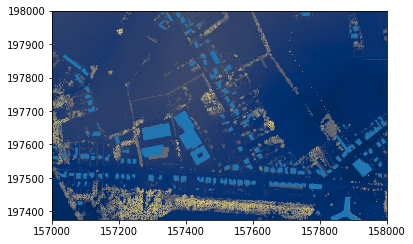

In [12]:
tif = GeoTIFF(data_lookup[(data_lookup.ROOT == "k23")
            &(data_lookup.PATH == "1_1_0_1_1")].DSM.values[0])
shape_file = get_containing_shape_file(tif.box, "CaBu")
get_shapes_in_box(shape_file, tif.box).plot()
tif.show()

## Get shapes in crop box

Address : Bosstraat 45 Duffel
Crop size: 100


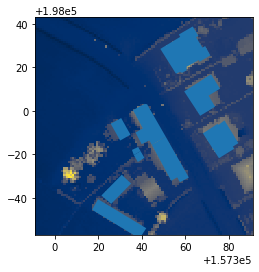

In [13]:
def get_lambert(address:str) -> (int,int):
    req = requests.get(f"http://loc.geopunt.be/geolocation/location?q={address}&c=1")
    return (req.json()["LocationResult"][0]["Location"]["X_Lambert72"],
            req.json()["LocationResult"][0]["Location"]["Y_Lambert72"])
x, y = get_lambert(input("Address : "))
size = int(input("Crop size: "))

tif = GeoTIFF.get_containing_tif(x, y, size)
crop = tif.crop_location(x, y, size)
shape_file = get_containing_shape_file(crop.box, "CaBu")
get_shapes_in_box(shape_file, crop.box).plot()
crop.show()

## Get root and sub path for location
I did some optimizing here by timing the old and new method

In [47]:
import time
import requests
import matplotlib.pyplot as plt
from dependencies import Box, GeoTIFF
def get_lambert(address:str) -> (int,int):
    req = requests.get(f"http://loc.geopunt.be/geolocation/location?q={address}&c=1")
    return (req.json()["LocationResult"][0]["Location"]["X_Lambert72"],
            req.json()["LocationResult"][0]["Location"]["Y_Lambert72"])
x, y = get_lambert(input("Address : "))

print(GeoTIFF.get_root_from_point(x, y))
print(GeoTIFF.get_sub_from_point(x, y))
start = time.time()
tif = GeoTIFF.get_tif_from_point(x, y)
print(f"took : {round(time.time() -start ,3)} seconds")

Address : Bosstraat 45 Duffel
k23
1_1_0_1_1
took : 0.014 seconds


**Bosstraat Duffel: K23/1_1_0_1_1**  
**Spoorweglei Sint-Kat: K23/1_1_3_2_0**  
**Molenstraat Sint-Kat: K24/0_0_2_1_3**  
**Beacon Antwerpen: K15/1_2_1_1_0**  

## Crunch the shape files

In [37]:
k23 = data_lookup[data_lookup.ROOT == "k23"]
k23

,ROOT,PATH,BOX,DSM,DTM,SHP
22550,k23,ROOT,130000 178000 162000 198000 32000 20000,NaN,NaN,NaN
22551,k23,0_0_0_0_0,130000 197375 131000 198000 1000 625,/media/becode/3D_House/Data/k23/0_0_0_0_0/DSM.tif,/media/becode/3D_House/Data/k23/0_0_0_0_0/DTM.tif,NaN
22552,k23,0_0_0_0_1,131000 197375 132000 198000 1000 625,/media/becode/3D_House/Data/k23/0_0_0_0_1/DSM.tif,/media/becode/3D_House/Data/k23/0_0_0_0_1/DTM.tif,NaN
22553,k23,0_0_0_0_2,130000 196750 131000 197375 1000 625,/media/becode/3D_House/Data/k23/0_0_0_0_2/DSM.tif,/media/becode/3D_House/Data/k23/0_0_0_0_2/DTM.tif,NaN
22554,k23,0_0_0_0_3,131000 196750 132000 197375 1000 625,/media/becode/3D_House/Data/k23/0_0_0_0_3/DSM.tif,/media/becode/3D_House/Data/k23/0_0_0_0_3/DTM.tif,NaN
...,...,...,...,...,...,...
23570,k23,3_3_3_2_3,159000 178000 160000 178625 1000 625,/media/becode/3D_House/Data/k23/3_3_3_2_3/DSM.tif,/media/becode/3D_House/Data/k23/3_3_3_2_3/DTM.tif,NaN
23571,k23,3_3_3_3_0,160000 178625 161000 179250 1000 625,/media/becode/3D_House/Data/k23/3_3_3_3_0/DSM.tif,/media/becode/3D_House/Data/k23/3_3_3_3_0/DTM.tif,NaN
23572,k23,3_3_3_3_1,161000 178625 162000 179250 1000 625,/media/becode/3D_House/Data/k23/3_3_3_3_1/DSM.tif,/media/becode/3D_House/Data/k23/3_3_3_3_1/DTM.tif,NaN
23573,k23,3_3_3_3_2,160000 178000 161000 178625 1000 625,/media/becode/3D_House/Data/k23/3_3_3_3_2/DSM.tif,/media/becode/3D_House/Data/k23/3_3_3_3_2/DTM.tif,NaN


In [58]:
box = Box.from_string(k23.loc[k23.index.min() +1].BOX)
start = time.time()
CaBu = get_containing_shape_file(box, "CaBu")
CaBu_shapes = get_shapes_in_box(CaBu, box).geometry if CaBu is not False else gpd.GeoDataFrame()
ReBu = get_containing_shape_file(box, "ReBu")
ReBu_shapes = get_shapes_in_box(ReBu, box).geometry if ReBu is not False else gpd.GeoDataFrame()
print(f"took : {time.time() -start} seconds")

took : 13.504003047943115 seconds


""


In [20]:
shapes_list = []
k15 = data_lookup[data_lookup.ROOT == "k15"]
for idx in range(k15.index.min() +1, k15.index.max() +1):
    if idx > k15.index.min() +10: break
        
    start = time.time()
    box = Box.from_string(k15.loc[idx].BOX)
    cabu = get_containing_shape_file(box, "CaBu")
    shapes_list.append(get_shapes_in_box(cabu, box))
    print(f"{idx} took : {round(time.time() -start, 3)} seconds")

AttributeError: 'bool' object has no attribute 'geometry'

## Populate DTM

In [27]:
import re
import pandas as pd
populate = pd.read_csv("./Data/data_lookup.csv", sep="|")
populate.DTM = populate.DSM
populate.DTM = populate.DTM.apply(lambda x:re.sub("S","T",x) if pd.notnull(x) else x)

In [30]:
populate.to_csv("./Data/data_lookup.csv",index=False, sep="|")

In [3]:
data_lookup

NameError: name 'data_lookup' is not defined